# Overview of Part I

As we start our journey into Big Data Analytics, the first thing we need to do is **get the data** in the form we need for analysis!  We'll start with an overview of how to acquire and *wrangle* data.

This notebook gives us a series of examples for:

* Acquiring data from files and remote sources
* Information extraction over HTML content
* A basic "vocabulary" of operators over tables (the relational algebra)

* "Data wrangling" or integration:
  * Cleaning and filtering data, using rules and based operations
  * Linking data across dataframes or relations
  * The need for approximate match and record linking

## The Motivating Question
To illustrate the principles, we focus on the question of how old company CEOs and founders are.  The question was in part motivated by the following New York Times article:

* Founders of Successful Tech Companies Are Mostly Middle-Aged: https://www.nytimes.com/2019/08/29/business/tech-start-up-founders-nest.html?searchResultPosition=2

So let's test this hypothesis!

In [2]:
# Let's install some libraries useful for processing web data

# For string similarity
!pip3 install py_stringsimjoin

# # lxml to parse xml tree
!pip3 install lxml

     |████████████████████████████████| 1.1 MB 4.4 MB/s 
     |████████████████████████████████| 661 kB 42.6 MB/s 
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.2-cp37-cp37m-linux_x86_64.whl size=3724122 sha256=2f54a992a652203503c222fc3398f34d1db68fa7dc6ec2d16eda4ed74eb76f0c
  Stored in directory: /root/.cache/pip/wheels/7c/0d/a4/c0a779a4d196bed8ed41ca12be09a93e158e4fc974b59f9fd5
  Created wheel for py-stringmatching: filename=py_stringmatching-0.4.2-cp37-cp37m-linux_x86_64.whl size=2055557 sha256=637f926c4456e5c6e40a8accd3c7440f8099ea89bc5052a9ab2726bb97ac2f83
  Stored in directory: /root/.cache/pip/wheels/7e/12/86/46f9378ae730550dd2f89cad50880e70d66cabedd90074f2d2
Successfully built py-stringsimjoin py-stringmatching


In [3]:
# Imports we'll use through the notebook, collected here for simplicity

# For parsing dates and being able to compare
import datetime

# For fetching remote data
import urllib
import urllib.request

# Pandas dataframes and operations
import pandas as pd

# Numpy matrix and array operations
import numpy as np

# Sqlite is a simplistic database
import sqlite3

# Approximate string matching, see 
import py_stringsimjoin as ssj
import py_stringmatching as sm

# Data visualization
import matplotlib



# Lecture Module 1: Acquiring Data

To test our hypothesis, we might want:

1. A list of companies (and, for futher details, perhaps their lines of business)
2. A list of company CEOs
3. Ages of the CEOs

We'll go through each of these using real data from the web.

### Reading Structured Data Sources

Let's start by looking up data about companies.  An example of this is at:

https://gist.githubusercontent.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv

which has some nicely detailed information about companies, their categories, when they were founded, etc.  Let's load this (remote) CSV file into a dataframe.

In [4]:
data = urllib.request.urlopen(\
       'https://gist.github.com/jvilledieu/c3afe5bc21da28880a30/raw/a344034b82a11433ba6f149afa47e57567d4a18f/Companies.csv')

company_data_df = pd.read_csv(data)
    

In [5]:
# Let's write it to SQL, and read it back

conn = sqlite3.connect('local.db')

company_data_df.to_sql("companies", conn, if_exists="replace", index=False)

pd.read_sql_query('select * from companies', conn)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1 750 000,acquired,USA,NY,New York City,New York,1,01/06/2012,2012-06,2012-Q2,2012.0,30/06/2012,30/06/2012
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4 000 000,operating,USA,CA,Los Angeles,Los Angeles,2,None,None,None,NaN,04/06/2010,23/09/2010
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40 000,operating,EST,None,Tallinn,Tallinn,1,26/10/2012,2012-10,2012-Q4,2012.0,09/08/2012,09/08/2012
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|iPhone|Apps|Mobile|iOS|E-Commerce|,Electronics,1 500 000,operating,GBR,None,London,London,1,01/04/2011,2011-04,2011-Q2,2011.0,01/04/2011,01/04/2011
4,/organization/n-plusn,+n (PlusN),http://plusn.com,|Software|,Software,1 200 000,operating,USA,NY,New York City,New York,2,01/01/2012,2012-01,2012-Q1,2012.0,29/08/2012,04/09/2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47753,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|Android|Education|,Education,320 000,operating,GBR,None,London,London,1,28/01/2013,2013-01,2013-Q1,2013.0,24/03/2014,24/03/2014
47754,/organization/zznode-science-and-technology-co-ltd,ZZNode Science and Technology,http://www.zznode.com,|Enterprise Software|,Enterprise Software,1 587 301,operating,CHN,None,Beijing,Beijing,1,None,None,None,NaN,01/04/2012,01/04/2012
47755,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,97 398,operating,HRV,None,Split,Split,5,13/05/2012,2012-05,2012-Q2,2012.0,01/11/2011,10/09/2014
47756,/organization/a-list-games,[a]list games,http://www.alistgames.com,|Games|,Games,9 300 000,operating,None,None,None,None,1,None,None,None,NaN,21/11/2011,21/11/2011


## Companies' CEOs: a Web Table

Now we need to figure out who the CEOs are for corporations.  One place to look is Wikipedia, which has an HTML table describing the CEOs.

https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs

Pandas actually makes it easy to read HTML tables...

In [6]:
# Now let's read an HTML table!

company_ceos_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_chief_executive_officers#List_of_CEOs')[0]

company_ceos_df

,Company,Executive,Title,Since,Notes,Updated
0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31
1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01
2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01
3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01
4,Airbus,Guillaume Faury,CEO[5],2012,Succeeded Louis Gallois,2017-11-14
...,...,...,...,...,...,...
178,Wipro,Thierry Delaporte,CEO[161],2016,Previously with Tata Consultancy Services,2017-11-11
179,WWE,Vince McMahon,Chairman and CEO[162],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980 to 1993,2017-11-11
180,Yum! Brands,Greg Creed,CEO[163],2015,Previously CEO for Taco Bell,2017-11-11
181,Zillow Group,Rich Barton,CEO[164],2019,Co-founder and previously was Zillow's CEO for nearly a decade. Succeeded Spencer Rascoff.,2018-12-10


## The Problem Gets Harder... Extracting Structured Fields

So far we have companies and CEOs.  But we don't have information on how old the CEOs are!

For a solution, we're going to go back to Wikipedia -- this time looking at the web pages for the CEOs!

This involves "crawling" the CEO pages, and "scraping" the relevant content.  In other words we have to do *information extraction*.

We'll start by constructing a list of CEO web pages, from the Company CEO dataframe above.  For this, we need to take the names and do a bit of tweaking, for example adding underscores instead of spaces.

In [7]:
crawl_list = []

for executive in company_ceos_df['Executive']:
  crawl_list.append('https://en.wikipedia.org/wiki/' + executive.replace(' ', '_'))
 
crawl_list

['https://en.wikipedia.org/wiki/Julie_Sweet',
 'https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla',
 'https://en.wikipedia.org/wiki/Shantanu_Narayen',
 'https://en.wikipedia.org/wiki/Garo_H._Armen',
 'https://en.wikipedia.org/wiki/Guillaume_Faury',
 'https://en.wikipedia.org/wiki/Daniel_Zhang',
 'https://en.wikipedia.org/wiki/Andy_Jassy',
 'https://en.wikipedia.org/wiki/Lisa_Su',
 'https://en.wikipedia.org/wiki/Stephen_Squeri',
 'https://en.wikipedia.org/wiki/Doug_Parker',
 'https://en.wikipedia.org/wiki/Joseph_R._Swedish',
 'https://en.wikipedia.org/wiki/Tim_Cook',
 'https://en.wikipedia.org/wiki/Lakshmi_Niwas_Mittal',
 'https://en.wikipedia.org/wiki/John_Stankey',
 'https://en.wikipedia.org/wiki/Charles_Woodburn',
 'https://en.wikipedia.org/wiki/Tapan_Singhel',
 'https://en.wikipedia.org/wiki/Carlos_Torres_Vila',
 'https://en.wikipedia.org/wiki/Brian_Moynihan',
 'https://en.wikipedia.org/wiki/Jes_Staley',
 'https://en.wikipedia.org/wiki/Warren_Buffett',
 'https://en.wikipedia.org/wi

In [8]:
# Use urllib.urlopen to crawl all pages in crawl_list, and store the response of the page
# in list pages 

pages = []

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url
    print('Looking at file %s' % page)

    # An issue: some of the accent characters won't work.  We need to convert them
    # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
    # the structure, then re-form the URL
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = urllib.request.urlopen((url_ascii))
      #Save page and url for later use.
      pages.append(response)
    except urllib.error.URLError as e:
      print(e.reason)


Looking at file Julie_Sweet
Looking at file Kumar_Mangalam_Birla
Looking at file Shantanu_Narayen
Looking at file Garo_H._Armen
Looking at file Guillaume_Faury
Looking at file Daniel_Zhang
Looking at file Andy_Jassy
Looking at file Lisa_Su
Looking at file Stephen_Squeri
Looking at file Doug_Parker
Looking at file Joseph_R._Swedish
Looking at file Tim_Cook
Looking at file Lakshmi_Niwas_Mittal
Looking at file John_Stankey
Looking at file Charles_Woodburn
Looking at file Tapan_Singhel
Looking at file Carlos_Torres_Vila
Looking at file Brian_Moynihan
Looking at file Jes_Staley
Looking at file Warren_Buffett
Looking at file Hubert_Joly
Looking at file Sunil_Bharti_Mittal
Looking at file Stephen_A._Schwarzman
Looking at file Andrew_Mackenzie
Looking at file Oliver_Zipse
Looking at file Dave_Calhoun
Looking at file Rich_Lesser
Looking at file Bob_Dudley
Looking at file Denise_Morrison
Looking at file Mark_Shuttleworth
Looking at file Aiman_Ezzat
Not Found
Looking at file Richard_Fairbank
Look

## Populating the Table with Executives

In [9]:
# Use lxml.etree.HTML(...) on the HTML content of each page to get a DOM tree that
# can be processed via XPath to extract the bday information.  Store the CEO name, 
# webpage, and the birthdate (born) in exec_df.

# We first check that the HTML content has a table of type `vcard`,
# and then extract the `bday` information.  If there is no birthdate, the datetime 
# value is NaT (not a type). 

from lxml import etree

exec_df = pd.DataFrame(columns=['name','page','born'])

for page in pages:    
    tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
    url = page.geturl()
    bday = tree.xpath('//table[contains(@class,"vcard")]//span[@class="bday"]/text()')
    if len(bday) > 0:
        name = url[url.rfind('/')+1:] # The part of the URL after the last /
        exec_df = exec_df.append({'name': name, 'page': url,
                   'born': datetime.datetime.strptime(bday[0], '%Y-%m-%d')}, ignore_index=True)
    else: 
            exec_df = exec_df.append({'name': url[url.rfind('/')+1:], 'page': url
                                      , 'born': None}, ignore_index=True)
        
exec_df

,name,page,born
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-26 00:00:00
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31 00:00:00
4,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00
...,...,...,...
173,Laura_J._Alber,https://en.wikipedia.org/wiki/Laura_J._Alber,None
174,Vince_McMahon,https://en.wikipedia.org/wiki/Vince_McMahon,1945-08-24 00:00:00
175,Greg_Creed,https://en.wikipedia.org/wiki/Greg_Creed,None
176,Rich_Barton,https://en.wikipedia.org/wiki/Rich_Barton,None


# Lecture Module 2: Data Transformation

Looking at our data to clean via *projection*...

Generally, we can extract one "narrower" table form another by using **double brackets**.

In [10]:
# Let's take a look at the data.  Here's a way of PROJECTING the exec_df dataframe into
# a smaller table

exec_df[['name', 'born']]

,name,born
0,Julie_Sweet,NaT
1,Kumar_Mangalam_Birla,1967-06-14 00:00:00
2,Shantanu_Narayen,1963-05-26 00:00:00
3,Garo_H._Armen,1953-01-31 00:00:00
4,Guillaume_Faury,1968-02-22 00:00:00
...,...,...
173,Laura_J._Alber,None
174,Vince_McMahon,1945-08-24 00:00:00
175,Greg_Creed,None
176,Rich_Barton,None


In [11]:
# Notice anything awry?

for person in exec_df['name']:
    print (person)

Julie_Sweet
Kumar_Mangalam_Birla
Shantanu_Narayen
Garo_H._Armen
Guillaume_Faury
Daniel_Zhang
Andy_Jassy
Lisa_Su
Stephen_Squeri
Doug_Parker
Joseph_R._Swedish
Tim_Cook
Lakshmi_Niwas_Mittal
John_Stankey
Charles_Woodburn
Tapan_Singhel
Carlos_Torres_Vila
Brian_Moynihan
Jes_Staley
Warren_Buffett
Hubert_Joly
Sunil_Bharti_Mittal
Stephen_A._Schwarzman
Andrew_Mackenzie
Oliver_Zipse
Dave_Calhoun
Rich_Lesser
Bob_Dudley
Denise_Morrison
Mark_Shuttleworth
Richard_Fairbank
Jim_Umpleby
Evan_G._Greenberg
Chuck_Robbins
Jane_Fraser
James_Quincey
Brian_Humphries
Brian_L._Roberts
Tidjane_Thiam
Ola_K%C3%A4llenius
Michael_Dell
Ed_Bastian
Christian_Sewing
Frank_Appel
Roland_Dickey_Jr.
Edward_D._Breen
G._V._Prasad
Devin_Wenig
Andrew_Wilson
B%C3%B6rje_Ekholm
Darren_Woods
Lisa_S._Jones
Carmine_Di_Sibio
Mark_Zuckerberg
Frederick_W._Smith
Sergio_Marchionne
Abigail_Johnson
James_Michael_Lafferty
James_Hackett
Terry_Gou
Lachlan_Murdoch
Daymond_John
Phebe_Novakovic
H._Lawrence_Culp_Jr.
Mary_T._Barra
Emma_Walmsley
Davi

In [12]:
def to_space(x):
  return x.replace('_', ' ')

# Let's use *apply* to call a function over each element, returning a new Series
exec_df['name'].apply(to_space)

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
173          Laura J. Alber
174           Vince McMahon
175              Greg Creed
176             Rich Barton
177               Eric Yuan
Name: name, Length: 178, dtype: object

In [13]:
# Let's use *apply* to call a function over each element, returning a new Series
exec_df['name'].apply(lambda x: x.replace('_', ' '))

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
173          Laura J. Alber
174           Vince McMahon
175              Greg Creed
176             Rich Barton
177               Eric Yuan
Name: name, Length: 178, dtype: object

In [14]:
# I can also use *apply* to call a function over the rows of a dataframe
exec_df.apply(lambda x: x['name'].replace('_', ' '), axis=1)

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
173          Laura J. Alber
174           Vince McMahon
175              Greg Creed
176             Rich Barton
177               Eric Yuan
Length: 178, dtype: object

In [15]:
# Let's clean the name by removing underscores...
exec_df['clean_name'] = exec_df['name'].apply(lambda x: x.replace('_', ' '))

exec_df

,name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-26 00:00:00,Shantanu Narayen
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31 00:00:00,Garo H. Armen
4,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
...,...,...,...,...
173,Laura_J._Alber,https://en.wikipedia.org/wiki/Laura_J._Alber,None,Laura J. Alber
174,Vince_McMahon,https://en.wikipedia.org/wiki/Vince_McMahon,1945-08-24 00:00:00,Vince McMahon
175,Greg_Creed,https://en.wikipedia.org/wiki/Greg_Creed,None,Greg Creed
176,Rich_Barton,https://en.wikipedia.org/wiki/Rich_Barton,None,Rich Barton


In [16]:
exec_df.rename(columns={'name': 'old_name'})

,old_name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-26 00:00:00,Shantanu Narayen
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31 00:00:00,Garo H. Armen
4,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
...,...,...,...,...
173,Laura_J._Alber,https://en.wikipedia.org/wiki/Laura_J._Alber,None,Laura J. Alber
174,Vince_McMahon,https://en.wikipedia.org/wiki/Vince_McMahon,1945-08-24 00:00:00,Vince McMahon
175,Greg_Creed,https://en.wikipedia.org/wiki/Greg_Creed,None,Greg Creed
176,Rich_Barton,https://en.wikipedia.org/wiki/Rich_Barton,None,Rich Barton


In [17]:
# We can do the same via SQL.  For the example we'll save the dataframe first...  we'll convert 
# types to string first to avoid errors.

temp_df= exec_df.applymap(str)
temp_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('select name, replace(name, "_", " ") as clean_name from temp_exec', conn)

,name,clean_name
0,Julie_Sweet,Julie Sweet
1,Kumar_Mangalam_Birla,Kumar Mangalam Birla
2,Shantanu_Narayen,Shantanu Narayen
3,Garo_H._Armen,Garo H. Armen
4,Guillaume_Faury,Guillaume Faury
...,...,...
173,Laura_J._Alber,Laura J. Alber
174,Vince_McMahon,Vince McMahon
175,Greg_Creed,Greg Creed
176,Rich_Barton,Rich Barton


## Selecting a subset of the rows

In [18]:
# Here's a column

exec_df['clean_name']

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
173          Laura J. Alber
174           Vince McMahon
175              Greg Creed
176             Rich Barton
177               Eric Yuan
Name: clean_name, Length: 178, dtype: object

In [19]:
# We can apply a test (predicate) to each column, returning a Series of boolean true/false values

exec_df['clean_name'] == 'Julie Sweet'

0       True
1      False
2      False
3      False
4      False
       ...  
173    False
174    False
175    False
176    False
177    False
Name: clean_name, Length: 178, dtype: bool

In [20]:
# If we compose these, we'll get only those rows where the boolean condition was True

exec_df[exec_df['clean_name'] == 'Julie Sweet']

,name,page,born,clean_name
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet


In [21]:
exec_df[exec_df['clean_name'] == 'Julie Sweet'][['page']]

,page
0,https://en.wikipedia.org/wiki/Julie_Sweet


In [22]:
# And in SQL...

temp_df= exec_df.applymap(str)
temp_df.to_sql('temp_exec', conn, if_exists="replace")

pd.read_sql_query('select * from temp_exec where clean_name="Julie Sweet"', conn)

,index,name,page,born,clean_name
0,0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet


In [23]:
pd.read_sql_query('select page from temp_exec where clean_name="Julie Sweet"', conn)

,page
0,https://en.wikipedia.org/wiki/Julie_Sweet


In [24]:
import numpy as np

exec_df.dropna(subset=['born'])

,name,page,born,clean_name
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-26 00:00:00,Shantanu Narayen
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31 00:00:00,Garo H. Armen
4,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
5,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,1972-01-11 00:00:00,Daniel Zhang
...,...,...,...,...
168,Doug_McMillon,https://en.wikipedia.org/wiki/Doug_McMillon,1966-10-17 00:00:00,Doug McMillon
170,Jason_Kilar,https://en.wikipedia.org/wiki/Jason_Kilar,1971-04-26 00:00:00,Jason Kilar
171,Charles_Scharf,https://en.wikipedia.org/wiki/Charles_Scharf,1965-04-24 00:00:00,Charles Scharf
174,Vince_McMahon,https://en.wikipedia.org/wiki/Vince_McMahon,1945-08-24 00:00:00,Vince McMahon


In [25]:
pd.read_sql_query('select * from temp_exec where born is not null', conn).set_index('index')

,name,page,born,clean_name
index,,,,
0,Julie_Sweet,https://en.wikipedia.org/wiki/Julie_Sweet,NaT,Julie Sweet
1,Kumar_Mangalam_Birla,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,1967-06-14 00:00:00,Kumar Mangalam Birla
2,Shantanu_Narayen,https://en.wikipedia.org/wiki/Shantanu_Narayen,1963-05-26 00:00:00,Shantanu Narayen
3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31 00:00:00,Garo H. Armen
4,Guillaume_Faury,https://en.wikipedia.org/wiki/Guillaume_Faury,1968-02-22 00:00:00,Guillaume Faury
...,...,...,...,...
173,Laura_J._Alber,https://en.wikipedia.org/wiki/Laura_J._Alber,None,Laura J. Alber
174,Vince_McMahon,https://en.wikipedia.org/wiki/Vince_McMahon,1945-08-24 00:00:00,Vince McMahon
175,Greg_Creed,https://en.wikipedia.org/wiki/Greg_Creed,None,Greg Creed


## Joining Data

We start with a simple join between company_ceos_df and exec_df and persist it to the database.  We then check how many companies did not have a match on CEO name.

In [26]:
exec_df[['clean_name', 'born']]

,clean_name,born
0,Julie Sweet,NaT
1,Kumar Mangalam Birla,1967-06-14 00:00:00
2,Shantanu Narayen,1963-05-26 00:00:00
3,Garo H. Armen,1953-01-31 00:00:00
4,Guillaume Faury,1968-02-22 00:00:00
...,...,...
173,Laura J. Alber,None
174,Vince McMahon,1945-08-24 00:00:00
175,Greg Creed,None
176,Rich Barton,None


In [27]:
company_ceos_df[['Executive', 'Company']]

,Executive,Company
0,Julie Sweet,Accenture
1,Kumar Mangalam Birla,Aditya Birla Group
2,Shantanu Narayen,Adobe Systems
3,Garo H. Armen,Agenus
4,Guillaume Faury,Airbus
...,...,...
178,Thierry Delaporte,Wipro
179,Vince McMahon,WWE
180,Greg Creed,Yum! Brands
181,Rich Barton,Zillow Group


In [28]:
company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'])

,Executive,Company,clean_name,born
0,Julie Sweet,Accenture,Julie Sweet,NaT
1,Kumar Mangalam Birla,Aditya Birla Group,Kumar Mangalam Birla,1967-06-14 00:00:00
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-26 00:00:00
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31 00:00:00
4,Guillaume Faury,Airbus,Guillaume Faury,1968-02-22 00:00:00
...,...,...,...,...
170,Laura J. Alber,Williams-Sonoma,Laura J. Alber,None
171,Vince McMahon,WWE,Vince McMahon,1945-08-24 00:00:00
172,Greg Creed,Yum! Brands,Greg Creed,None
173,Rich Barton,Zillow Group,Rich Barton,None


In [29]:
temp_df= company_ceos_df.applymap(str)
temp_df.to_sql('company_ceos', conn, if_exists="replace")
temp_df= exec_df.applymap(str)
temp_df.to_sql('executives', conn, if_exists="replace")
company_data_df.to_sql('company_data', conn, if_exists='replace')

pd.read_sql_query('select Executive, Company, born from company_ceos ' +\
                  'join executives on Executive=clean_name ' +\
                  'where born is not null', conn)

,Executive,Company,born
0,Julie Sweet,Accenture,NaT
1,Kumar Mangalam Birla,Aditya Birla Group,1967-06-14 00:00:00
2,Shantanu Narayen,Adobe Systems,1963-05-26 00:00:00
3,Garo H. Armen,Agenus,1953-01-31 00:00:00
4,Guillaume Faury,Airbus,1968-02-22 00:00:00
...,...,...,...
170,Laura J. Alber,Williams-Sonoma,None
171,Vince McMahon,WWE,1945-08-24 00:00:00
172,Greg Creed,Yum! Brands,None
173,Rich Barton,Zillow Group,None


###Finding the misses in the join.

Note that the join above resulted in 174 rows.  However, there are more rows in company_ceos_df so we are missing some companies.  We can see which are missed using a left outer join; setting "indicator= True" allows us to see which tuples in company_ceos_df failed to find a match (left_only, e.g. row 24 and 172).

In [30]:
pd.set_option('display.max_rows', 200)
display(company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'], how="left", indicator=True))



,Executive,Company,clean_name,born,_merge
0,Julie Sweet,Accenture,Julie Sweet,NaT,both
1,Kumar Mangalam Birla,Aditya Birla Group,Kumar Mangalam Birla,1967-06-14 00:00:00,both
2,Shantanu Narayen,Adobe Systems,Shantanu Narayen,1963-05-26 00:00:00,both
3,Garo H. Armen,Agenus,Garo H. Armen,1953-01-31 00:00:00,both
4,Guillaume Faury,Airbus,Guillaume Faury,1968-02-22 00:00:00,both
5,Daniel Zhang,Alibaba,Daniel Zhang,1972-01-11 00:00:00,both
6,Andy Jassy,Amazon,Andy Jassy,1968-01-13 00:00:00,both
7,Lisa Su,Advanced Micro Devices,Lisa Su,1969-11-07 00:00:00,both
8,Stephen Squeri,American Express,Stephen Squeri,NaT,both
9,Doug Parker,American Airlines Group,Doug Parker,1961-10-31 00:00:00,both


In [31]:
pd.set_option('display.max_rows', 50)
result_df = company_ceos_df[['Executive', 'Company']].merge(exec_df[['clean_name', 'born']], 
                                                left_on=['Executive'], 
                                                right_on=['clean_name'], how="outer", indicator=True)

result_df[result_df['_merge'] != 'both']


,Executive,Company,clean_name,born,_merge
30,Aiman Ezzat,Capgemini,NaN,NaN,left_only
40,Ola Källenius,Daimler AG,NaN,NaN,left_only
50,Börje Ekholm,Ericsson,NaN,NaN,left_only
91,Andrew Meslow,"Bath & Body Works, Inc.",NaN,NaN,left_only
109,Sapnesh Lalla,NIIT,NaN,NaN,left_only
130,Michael O'Leary,Ryanair,NaN,NaN,left_only
157,Umberto Macchi di Cellere,Tod's,NaN,NaN,left_only
178,Thierry Delaporte,Wipro,NaN,NaN,left_only
183,NaN,NaN,Ola K%C3%A4llenius,1969-06-11 00:00:00,right_only
184,NaN,NaN,B%C3%B6rje Ekholm,NaT,right_only


## Composing Joins



In [32]:
pd.read_sql_query('select Executive, Company, born  from company_ceos ' +\
                  'join executives on Executive=clean_name join company_data cd on Company=cd.name ' +\
                  'where born is not null', conn)

,Executive,Company,born
0,Garo H. Armen,Agenus,1953-01-31 00:00:00
1,Daniel Zhang,Alibaba,1972-01-11 00:00:00
2,Andy Jassy,Amazon,1968-01-13 00:00:00
3,Charles Woodburn,BAE Systems,NaT
4,Mark Shuttleworth,Canonical,1973-09-18 00:00:00
5,Brian L. Roberts,Comcast,1959-06-28 00:00:00
6,Devin Wenig,eBay,NaT
7,Mark Zuckerberg,Facebook,1984-05-14 00:00:00
8,Phebe Novakovic,General Dynamics,NaT
9,H. Lawrence Culp Jr.,General Electric,NaT


In [33]:
pd.read_sql_query('select * from company_ceos ' +\
                  'join executives on Executive=clean_name join company_data cd on Company=cd.name ' +\
                  'where born is not null', conn)

,index,Company,Executive,Title,Since,Notes,Updated,index,name,page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,...,MA,Boston,Lexington,2,01/01/1994,1994-01,1994-Q1,1994.0,04/08/2009,25/04/2013
1,5,Alibaba,Daniel Zhang,CEO[6],2015,Previously with Taobao,2018-10-01,5,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,...,None,Hangzhou,Hangzhou,4,01/06/1999,1999-06,1999-Q2,1999.0,01/10/1999,11/08/2005
2,6,Amazon,Andy Jassy,CEO and president[7],2021,nan,nan,6,Andy_Jassy,https://en.wikipedia.org/wiki/Andy_Jassy,...,WA,Seattle,Seattle,1,01/01/1994,1994-01,1994-Q1,1994.0,01/07/1995,01/07/1995
3,14,BAE Systems,Charles Woodburn,Chief Executive Officer[15],2008,Succeeded Ian King,2018-10-01,14,Charles_Woodburn,https://en.wikipedia.org/wiki/Charles_Woodburn,...,MD,"Washington, D.C.",Rockville,2,01/11/1999,1999-11,1999-Q4,1999.0,30/11/2009,10/09/2010
4,29,Canonical,Mark Shuttleworth,Founder and CEO[29],2017,Stepped down as CEO in 2009 and resumed in 2017,2017-11-14,29,Mark_Shuttleworth,https://en.wikipedia.org/wiki/Mark_Shuttleworth,...,None,London,London,1,01/01/2004,2004-01,2004-Q1,2004.0,16/08/2013,16/08/2013
5,38,Comcast,Brian L. Roberts,Chairman and CEO[38],2002,"Son of Ralph J. Roberts, the founder of Comcast",2017-11-14,37,Brian_L._Roberts,https://en.wikipedia.org/wiki/Brian_L._Roberts,...,PA,Philadelphia,Philadelphia,1,01/01/1963,1963-01,1963-Q1,1963.0,08/05/2013,08/05/2013
6,48,eBay,Devin Wenig,President and CEO[46],2015,"Third CEO of the company, after Meg Whitman and John Donahoe",2017-11-14,47,Devin_Wenig,https://en.wikipedia.org/wiki/Devin_Wenig,...,CA,SF Bay Area,San Jose,1,01/09/1995,1995-09,1995-Q3,1995.0,01/06/1997,01/06/1997
7,54,Facebook,Mark Zuckerberg,Chairman and CEO,2004,Co-founded Facebook in 2004,2017-11-14,53,Mark_Zuckerberg,https://en.wikipedia.org/wiki/Mark_Zuckerberg,...,CA,SF Bay Area,Menlo Park,11,04/02/2004,2004-02,2004-Q1,2004.0,01/09/2004,21/01/2011
8,63,General Dynamics,Phebe Novakovic,Chairman and CEO[56],2014,Worked for the Central Intelligence Agency and the United States Department of Defense,2017-11-14,62,Phebe_Novakovic,https://en.wikipedia.org/wiki/Phebe_Novakovic,...,VA,"Washington, D.C.",Falls Church,3,01/01/1952,1952-01,1952-Q1,1952.0,05/08/2009,10/09/2010
9,64,General Electric,H. Lawrence Culp Jr.,Chairman and CEO,2018,"Prior to joining GE, Culp worked at Danaher Corporation in Washington, D.C.",2018-10-01,63,H._Lawrence_Culp_Jr.,https://en.wikipedia.org/wiki/H._Lawrence_Culp_Jr.,...,CT,Hartford,Fairfield,1,1890-01-01,None,None,NaN,19/11/2009,19/11/2009


In [34]:
company_ceos_df.merge(exec_df, 
                      left_on=['Executive'], 
                      right_on=['clean_name']).\
                      merge(company_data_df,
                            left_on='Company',
                            right_on='name')

,Company,Executive,Title,Since,Notes,Updated,name_x,page,born,clean_name,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,Garo_H._Armen,https://en.wikipedia.org/wiki/Garo_H._Armen,1953-01-31 00:00:00,Garo H. Armen,...,MA,Boston,Lexington,2,01/01/1994,1994-01,1994-Q1,1994.0,04/08/2009,25/04/2013
1,Alibaba,Daniel Zhang,CEO[6],2015,Previously with Taobao,2018-10-01,Daniel_Zhang,https://en.wikipedia.org/wiki/Daniel_Zhang,1972-01-11 00:00:00,Daniel Zhang,...,NaN,Hangzhou,Hangzhou,4,01/06/1999,1999-06,1999-Q2,1999.0,01/10/1999,11/08/2005
2,Amazon,Andy Jassy,CEO and president[7],2021,NaN,NaN,Andy_Jassy,https://en.wikipedia.org/wiki/Andy_Jassy,1968-01-13 00:00:00,Andy Jassy,...,WA,Seattle,Seattle,1,01/01/1994,1994-01,1994-Q1,1994.0,01/07/1995,01/07/1995
3,BAE Systems,Charles Woodburn,Chief Executive Officer[15],2008,Succeeded Ian King,2018-10-01,Charles_Woodburn,https://en.wikipedia.org/wiki/Charles_Woodburn,NaT,Charles Woodburn,...,MD,"Washington, D.C.",Rockville,2,01/11/1999,1999-11,1999-Q4,1999.0,30/11/2009,10/09/2010
4,Canonical,Mark Shuttleworth,Founder and CEO[29],2017,Stepped down as CEO in 2009 and resumed in 2017,2017-11-14,Mark_Shuttleworth,https://en.wikipedia.org/wiki/Mark_Shuttleworth,1973-09-18 00:00:00,Mark Shuttleworth,...,NaN,London,London,1,01/01/2004,2004-01,2004-Q1,2004.0,16/08/2013,16/08/2013
5,Comcast,Brian L. Roberts,Chairman and CEO[38],2002,"Son of Ralph J. Roberts, the founder of Comcast",2017-11-14,Brian_L._Roberts,https://en.wikipedia.org/wiki/Brian_L._Roberts,1959-06-28 00:00:00,Brian L. Roberts,...,PA,Philadelphia,Philadelphia,1,01/01/1963,1963-01,1963-Q1,1963.0,08/05/2013,08/05/2013
6,eBay,Devin Wenig,President and CEO[46],2015,"Third CEO of the company, after Meg Whitman and John Donahoe",2017-11-14,Devin_Wenig,https://en.wikipedia.org/wiki/Devin_Wenig,NaT,Devin Wenig,...,CA,SF Bay Area,San Jose,1,01/09/1995,1995-09,1995-Q3,1995.0,01/06/1997,01/06/1997
7,Facebook,Mark Zuckerberg,Chairman and CEO,2004,Co-founded Facebook in 2004,2017-11-14,Mark_Zuckerberg,https://en.wikipedia.org/wiki/Mark_Zuckerberg,1984-05-14 00:00:00,Mark Zuckerberg,...,CA,SF Bay Area,Menlo Park,11,04/02/2004,2004-02,2004-Q1,2004.0,01/09/2004,21/01/2011
8,General Dynamics,Phebe Novakovic,Chairman and CEO[56],2014,Worked for the Central Intelligence Agency and the United States Department of Defense,2017-11-14,Phebe_Novakovic,https://en.wikipedia.org/wiki/Phebe_Novakovic,NaT,Phebe Novakovic,...,VA,"Washington, D.C.",Falls Church,3,01/01/1952,1952-01,1952-Q1,1952.0,05/08/2009,10/09/2010
9,General Electric,H. Lawrence Culp Jr.,Chairman and CEO,2018,"Prior to joining GE, Culp worked at Danaher Corporation in Washington, D.C.",2018-10-01,H._Lawrence_Culp_Jr.,https://en.wikipedia.org/wiki/H._Lawrence_Culp_Jr.,NaT,H. Lawrence Culp Jr.,...,CT,Hartford,Fairfield,1,1890-01-01,NaN,NaN,NaN,19/11/2009,19/11/2009


# Lecture Module 3: Validating and Cleaning Data

How do we know our data is good?  We can create rules that trigger when the data fails some particular set of **constraints**.

In [35]:
# Test with validation rules

replace_item = ''

failed = False
for name in exec_df['clean_name']:
  if not name.replace(' ', replace_item).\
          replace('.', replace_item).\
          replace('\'',replace_item).\
          replace('-',replace_item).isalpha():
    print ("Illegal name %s"%name)
    failed = True
    
if failed:
  print('Found illegal names!')

Illegal name Ola K%C3%A4llenius
Illegal name B%C3%B6rje Ekholm
Illegal name Michael O%27Leary
Found illegal names!


## Data Cleaning: Fixing the Errors

One approach we could take is to realize that these are all strings in which accented characters are specially coded for use in (Wikipedia) URLs.  For instance, %C3 is a hex character code for an accented "u".  We can use a function called `unqote` to fix this...


In [36]:
from urllib.parse import unquote

exec_df['clean_name'].apply(unquote)

0               Julie Sweet
1      Kumar Mangalam Birla
2          Shantanu Narayen
3             Garo H. Armen
4           Guillaume Faury
               ...         
173          Laura J. Alber
174           Vince McMahon
175              Greg Creed
176             Rich Barton
177               Eric Yuan
Name: clean_name, Length: 178, dtype: object

## More Generally: Data Validation Tools

Are there tools to help us validate data?  Of course!  We see an [example](https://validators.readthedocs.io/en/latest/) of one such tool, simply called `validators`, below.  There are many others in the data cleaning literature.

In [37]:
!pip install validators

  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19553 sha256=d7a92ef16f527127289514a4dbcba3fa9044246d886922802332284e35970ce9
  Stored in directory: /root/.cache/pip/wheels/fe/5d/69/ff53a908b9f14fb7730a58fdede0fac4cdc99ef3624ec76d05
Successfully built validators


In [38]:
import validators.url

# Are all of the URLs valid?
exec_df['page'].apply(validators.url)

0      True
1      True
2      True
3      True
4      True
       ... 
173    True
174    True
175    True
176    True
177    True
Name: page, Length: 178, dtype: bool

## Validation against a master list

We can also compare against "master" lists (in tables).  For example, company info about stock ticker symbols can be compared against the full list of symbols; states and countries can be compared against definitive lists.

Suppose we want to confirm that `company_data_df` has valid country codes.  


In [39]:
company_data_df[['name','country_code']]

,name,country_code
0,#waywire,USA
1,&TV Communications,USA
2,'Rock' Your Paper,EST
3,(In)Touch Network,GBR
4,+n (PlusN),USA
...,...,...
47753,Zzish,GBR
47754,ZZNode Science and Technology,CHN
47755,Zzzzapp Wireless ltd.,HRV
47756,[a]list games,NaN


Some of these are NaNs -- let's drop them...

From someone's Github content, here's a nice list of all countries and region codes.

In [40]:
countries_df = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

display(countries_df)

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


In [41]:
validated = company_data_df.merge(countries_df, left_on=['country_code'], right_on=['alpha-3'],
                      how='left', indicator=True)

validated[validated['_merge'] != 'both']

,permalink,name_x,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region_x,...,alpha-3,country-code,iso_3166-2,region_y,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,_merge
8,/organization/0-6-com,0-6.com,http://www.0-6.com,|Curated Web|,Curated Web,2 000 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
19,/organization/1000-markets,1000 Markets,http://www.1000markets.com,|Marketplaces|Art|E-Commerce|,Marketplaces,500 000,acquired,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
25,/organization/100du-tv,100du.tv,http://www.100du.com,|Hospitality|,Hospitality,3 000 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
30,/organization/10sec,10sec,http://10s.ec/,|Social Commerce|E-Commerce|Mobile Commerce|,Mobile Commerce,1 600 000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
35,/organization/115-network-disks,115 network disks,http://www.115.com/,|Education|,Education,-,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47707,/organization/zura,Zura!,http://www.zura.com.br,|E-Commerce|,E-Commerce,-,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47712,/organization/zursh-2,Zursh,http://www.zursh.com/,NaN,NaN,25 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47729,/organization/zwoor-com,zwoor.com,http://www.zwoor.com,|Meeting Software|Polling|Surveys|Android|iPhone|iPad|Events|Mobile|,Polling,100 000,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47743,/organization/zympi,Zympi,http://www.zympi.com,|Networking|Web Hosting|Mobile|,Web Hosting,-,operating,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


## Record Linking: Working around the Errors

Rather than figuring out how to clean these characters, we'll instead look at doing approximate matching.

Now we'll need to import some similarity matching code, to do approximate match between the original names and those returned by Wikipedia


In [42]:
# We are going to match the strings approximately, via "n-grams" or "q-grams" (sequences of n or q characters)
# Here it's five-grams

tok = sm.QgramTokenizer(qval=5,return_set=True)

In [43]:
# Now let's do a similarity join

# We'll reset the index, so there is a unique index field in the company_ceos_df dataframe
company_ceos_df.reset_index(inplace=True)

output_pairs = ssj.jaccard_join(company_ceos_df, exec_df, 'index', 'page', 'Executive', 'clean_name', tok, 0.35, 
                                l_out_attrs=['Executive'], r_out_attrs=['name'])

output_pairs[output_pairs['_sim_score'] < 1.0]

/usr/local/lib/python3.7/dist-packages/py_stringsimjoin/utils/generic_helper.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  subset=[join_attr])
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,_id,l_index,r_page,l_Executive,r_name,_sim_score
39,39,40,https://en.wikipedia.org/wiki/Ola_K%C3%A4llenius,Ola Källenius,Ola_K%C3%A4llenius,0.444444
49,49,50,https://en.wikipedia.org/wiki/B%C3%B6rje_Ekholm,Börje Ekholm,B%C3%B6rje_Ekholm,0.423077
127,127,130,https://en.wikipedia.org/wiki/Michael_O%27Leary,Michael O'Leary,Michael_O%27Leary,0.538462


In [45]:
# At last! Company info + CEO info, together!

total = company_ceos_df.merge(output_pairs,left_on=['Executive'],right_on=['l_Executive']).\
        merge(exec_df,left_on=['r_page'],right_on=['page']).\
        merge(company_data_df, left_on='Company', right_on='name', how="left")

total

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,...,MA,Boston,Lexington,2.0,01/01/1994,1994-01,1994-Q1,1994.0,04/08/2009,25/04/2013
4,4,Airbus,Guillaume Faury,CEO[5],2012,Succeeded Louis Gallois,2017-11-14,4,4,https://en.wikipedia.org/wiki/Guillaume_Faury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,177,Williams-Sonoma,Laura J. Alber,President and CEO[160],2010,Replaced W. Howard Lester,2017-11-11,173,177,https://en.wikipedia.org/wiki/Laura_J._Alber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,179,WWE,Vince McMahon,Chairman and CEO[162],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980 to 1993,2017-11-11,174,179,https://en.wikipedia.org/wiki/Vince_McMahon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,180,Yum! Brands,Greg Creed,CEO[163],2015,Previously CEO for Taco Bell,2017-11-11,175,180,https://en.wikipedia.org/wiki/Greg_Creed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,181,Zillow Group,Rich Barton,CEO[164],2019,Co-founder and previously was Zillow's CEO for nearly a decade. Succeeded Spencer Rascoff.,2018-12-10,176,181,https://en.wikipedia.org/wiki/Rich_Barton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Let's get ready to plot

%matplotlib inline

In [47]:
total

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,0,Accenture,Julie Sweet,CEO[1],2019,"Succeeded Pierre Nanterme, died",2019-01-31,0,0,https://en.wikipedia.org/wiki/Julie_Sweet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Aditya Birla Group,Kumar Mangalam Birla,Chairman[2],1995[2],Part of the Birla family business house in India,2018-10-01,1,1,https://en.wikipedia.org/wiki/Kumar_Mangalam_Birla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Adobe Systems,Shantanu Narayen,"Chairman, president and CEO[3]",2007,Formerly with Apple,2018-10-01,2,2,https://en.wikipedia.org/wiki/Shantanu_Narayen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Agenus,Garo H. Armen,"Founder, chairman, CEO[4]",1994,Founder of the Children of Armenia Fund (COAF),2018-10-01,3,3,https://en.wikipedia.org/wiki/Garo_H._Armen,...,MA,Boston,Lexington,2.0,01/01/1994,1994-01,1994-Q1,1994.0,04/08/2009,25/04/2013
4,4,Airbus,Guillaume Faury,CEO[5],2012,Succeeded Louis Gallois,2017-11-14,4,4,https://en.wikipedia.org/wiki/Guillaume_Faury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,177,Williams-Sonoma,Laura J. Alber,President and CEO[160],2010,Replaced W. Howard Lester,2017-11-11,173,177,https://en.wikipedia.org/wiki/Laura_J._Alber,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,179,WWE,Vince McMahon,Chairman and CEO[162],2009,Chairman of the executive committeeChairman since 1980President and CEO from 1980 to 1993,2017-11-11,174,179,https://en.wikipedia.org/wiki/Vince_McMahon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,180,Yum! Brands,Greg Creed,CEO[163],2015,Previously CEO for Taco Bell,2017-11-11,175,180,https://en.wikipedia.org/wiki/Greg_Creed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,181,Zillow Group,Rich Barton,CEO[164],2019,Co-founder and previously was Zillow's CEO for nearly a decade. Succeeded Spencer Rascoff.,2018-12-10,176,181,https://en.wikipedia.org/wiki/Rich_Barton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Simple Analysis of Linked Data: Grouping and Analytics

The `groupby` command allows us to coalesce data by groups.  In Pandas a Group is a special object with a set of rows.  We can see this with the `get_group` command.

In [48]:
total[['born','Company','Executive']].sort_values('born')

,born,Company,Executive
72,1576-02-29 00:00:00,Hewlett Packard Enterprise,Antonio Neri
71,1928-03-07 00:00:00,Henderson Land Development,Lee Shau Kee
19,1930-08-30 00:00:00,Berkshire Hathaway,Warren Buffett
74,1934-12-14 00:00:00,HP Hood,John A. Kaneb
86,1935-11-01 00:00:00,Koch Industries,Charles G. Koch
...,...,...,...
169,None,Warner Brothers,Ann Sarnoff
172,None,Whole Foods Market,John Mackey
173,None,Williams-Sonoma,Laura J. Alber
175,None,Yum! Brands,Greg Creed


In [49]:
total.groupby(by='born').get_group(datetime.datetime.strptime('1945-08-24', '%Y-%m-%d'))[['Company','Executive','born']]

,Company,Executive,born
174,WWE,Vince McMahon,1945-08-24 00:00:00


In [50]:
total.groupby(by='born').count()

,index,Company,Executive,Title,Since,Notes,Updated,_id,l_index,r_page,...,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
born,,,,,,,,,,,,,,,,,,,,,
1576-02-29 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1928-03-07 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1930-08-30 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1934-12-14 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1935-11-01 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974-04-01 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1980-05-04 00:00:00,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1984-05-14 00:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [52]:
# We can do this in SQL too...

total.to_sql('total_info', conn, if_exists='replace', index=False)

# By default, SQL will include the Nan value (called NULL in SQL).  If we want to exclude it, 
# we need to include WHERE ... IS NOT NULL.

pd.read_sql('select born, count(Company) from total_info ' +\
            'where born is not null group by born', conn)

InterfaceError: ignored

In [53]:
# Let's look at when the CEOs were born

birthdays = total.groupby(by='born').count()[['Executive']]

birthdays

,Executive
born,
1576-02-29 00:00:00,1
1928-03-07 00:00:00,1
1930-08-30 00:00:00,1
1934-12-14 00:00:00,1
1935-11-01 00:00:00,1
...,...
1974-04-01 00:00:00,1
1980-05-04 00:00:00,1
1984-05-14 00:00:00,1


We can actually use `resample` over dates, with a parameter, to group eg by decade (10 years, where A is the code for year):

In [54]:
birthdays.resample('10A').count().plot(kind='bar')


TypeError: ignored

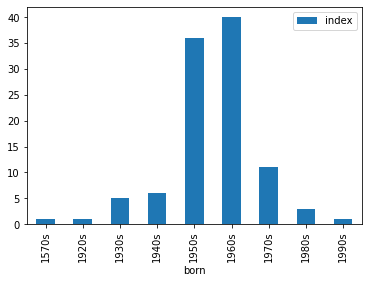

In [55]:
# Get rid of the nulls!
bdays = total[['born']].dropna()

bdays = bdays.applymap(lambda bday: str(int(bday.year / 10) * 10) + 's')

bdays.reset_index().groupby('born').count().plot(kind='bar')